<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:04<00:00, 41.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [8]:
num_epochs = 70
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')
    scheduler.step()

Epoch 1: Loss: 1.1592, Train Accuracy: 59.84%
Test Accuracy: 65.11%
Confusion Matrix (Epoch 1):
[[619  13  30  24  14   5   3   5 284   3]
 [ 40 744  27  17   1   1  12   2 147   9]
 [131   0 634  55  68  57  36   7  11   1]
 [ 30   3 118 631  46 101  52   6  12   1]
 [ 44   1 107  54 657  27  85   8  17   0]
 [ 20   0  96 228  45 580  19   8   4   0]
 [  8   0  99  66  16  15 785   0  11   0]
 [ 42   2  94  95 128  73  15 542   7   2]
 [ 80   7  13  18   4   3   0   3 872   0]
 [ 59 222  30  45   0  13   9  17 158 447]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 0.9226, Train Accuracy: 68.28%
Test Accuracy: 73.91%
Confusion Matrix (Epoch 2):
[[739  52  71  12   9  10   3  17  16  71]
 [  6 887   5   3   0   6   1   5   4  83]
 [ 42   6 649  23  81 109  27  45   2  16]
 [ 33   9  37 453  41 321  35  43   7  21]
 [ 24   3  48  43 713  54  16  93   2   4]
 [ 12   3  19  57  28 814   4  52   2   9]
 [  8  13  51  40  46  53 760   6   7  16]
 [  8   4  18  13  22  88   3 827   4  13]
 [179  86   9   8   4   3   0   4 670  37]
 [ 12  72   2   7   0   2   0  16  10 879]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 0.8071, Train Accuracy: 72.17%
Test Accuracy: 78.46%
Confusion Matrix (Epoch 3):
[[821  17  28  21  12   4   6  27  37  27]
 [  9 906   2   7   1   2   5   6  20  42]
 [ 62   4 668  39  73  71  47  28   6   2]
 [ 24   3  38 633  39 179  45  29   8   2]
 [ 11   1  28  46 790  30  34  52   8   0]
 [ 13   2  26 138  41 722  19  38   0   1]
 [  4  12  34  55  27  28 830   6   3   1]
 [ 17   1  20  29  26  55   3 844   2   3]
 [ 85  20   5  26   5   5   5   3 831  15]
 [ 27  83   5  26   0  10   2  19  27 801]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.8225, Train Accuracy: 71.74%
Test Accuracy: 75.73%
Confusion Matrix (Epoch 4):
[[552  40  48  16  20   5   8  10 254  47]
 [  2 904   3   8   0   4   3   2  29  45]
 [ 62  10 727  32  51  28  45  19  18   8]
 [ 14   5  92 556  35 190  54  30  12  12]
 [ 10   3  80  37 715  24  54  64  12   1]
 [  9   1  87  98  37 690  22  54   1   1]
 [  6   6  47  43  11  19 856   4   6   2]
 [ 13   5  43  33  23  40   3 829   4   7]
 [ 14  23   8   6   1   4   3   1 913  27]
 [  8  90   4  10   0   7   6   7  37 831]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.7209, Train Accuracy: 75.07%
Test Accuracy: 78.72%
Confusion Matrix (Epoch 5):
[[896  10  45   8   5   0   6   5  17   8]
 [ 20 932   5   0   0   3   6   2   9  23]
 [ 51   2 779  16  48  44  32  20   2   6]
 [ 34  12  66 477  56 228  56  60   4   7]
 [ 26   1  70   9 769  21  48  51   3   2]
 [ 16   5  34  73  41 751  18  56   3   3]
 [ 12   5  65  28  18  23 836   5   6   2]
 [ 30   3  23   8  20  31   7 870   3   5]
 [133  30  12   4   4   1   2   2 807   5]
 [ 75 118   5   3   2   4   6   2  30 755]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.6653, Train Accuracy: 76.96%
Test Accuracy: 80.53%
Confusion Matrix (Epoch 6):
[[847  10  37   4   6   5   5   6  65  15]
 [ 10 918   3   2   0   7   8   2   7  43]
 [ 50   0 778   8  58  43  40  10   7   6]
 [ 23   3  76 432  45 294  81  25  16   5]
 [ 13   1  59  20 796  41  22  37  11   0]
 [ 10   2  49  40  38 810  24  21   4   2]
 [  7   0  24  17  23  23 898   3   4   1]
 [ 15   1  27   4  27  66   6 845   5   4]
 [ 44  33   7   5   3   2   3   1 886  16]
 [ 36  70   2   4   1  10   3   7  24 843]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.6311, Train Accuracy: 78.07%
Test Accuracy: 80.53%
Confusion Matrix (Epoch 7):
[[884   8  15   6   5   2   4   6  58  12]
 [ 27 893   0   1   1   8   3   0  32  35]
 [ 88   3 733  19  53  55  30   9   8   2]
 [ 30   5  54 489  45 288  41  20  19   9]
 [ 23   1  58  16 793  37  40  23   8   1]
 [ 14   0  25  56  34 825  19  20   4   3]
 [ 15   4  27  26   9  32 866   4  16   1]
 [ 26   0  24  15  38  60   7 813   7  10]
 [ 47  10   2   3   2   5   1   1 928   1]
 [ 50  63   1   3   0   7   2   4  41 829]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.6244, Train Accuracy: 78.62%
Test Accuracy: 81.11%
Confusion Matrix (Epoch 8):
[[923   5  17   9   6   0   4   4  25   7]
 [ 35 902   2   1   2   2   6   2  20  28]
 [ 66   2 744  34  64  15  43  25   4   3]
 [ 33   6  41 663  59  71  69  39  12   7]
 [ 22   1  23  18 837   5  31  56   7   0]
 [ 15   2  39 181  46 626  26  60   2   3]
 [ 13   1  18  28  19   4 901   6   8   2]
 [ 26   2  18  24  22  11   7 886   3   1]
 [ 82  12  11   7   3   1   3   1 874   6]
 [102  88   3  10   3   0   1  15  23 755]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.6093, Train Accuracy: 79.16%
Test Accuracy: 78.33%
Confusion Matrix (Epoch 9):
[[721  31  95  22  13   6   4  10  42  56]
 [  3 943   1   4   0   3   0   0   2  44]
 [ 71  11 634  54  48  71  40  27  18  26]
 [  8  19  27 623  30 197  35  26   7  28]
 [ 17   7  40  45 729  57  29  51  10  15]
 [ 11  10  17 115  19 780  13  19   4  12]
 [  8  24  20  43  12  27 844   4  12   6]
 [ 14   6   5  25  16  43   4 857   2  28]
 [ 62  70   2   5   3   7   1   1 816  33]
 [ 14  79   0   3   0   4   2   0  12 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.5895, Train Accuracy: 79.68%
Test Accuracy: 82.70%
Confusion Matrix (Epoch 10):
[[831  11  51  10  19   2   4  11  39  22]
 [  7 913   2   5   1   6   1   3  11  51]
 [ 36   0 795  26  47  36  19  27   7   7]
 [ 16   4  48 569  44 222  22  63   9   3]
 [  9   1  38  17 839  25  14  49   7   1]
 [  8   1  27  78  30 805   5  44   2   0]
 [  5   4  45  39  17  38 833  10   5   4]
 [ 14   1  10   9  25  29   1 904   1   6]
 [ 45  19   8   7   4   3   0   2 897  15]
 [ 25  49   6   6   1   7   3   4  15 884]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.5711, Train Accuracy: 80.43%
Test Accuracy: 83.76%
Confusion Matrix (Epoch 11):
[[848   9  52  10   6   1   7   3  47  17]
 [ 11 921   8   5   0   4   3   1  10  37]
 [ 34   2 820  25  46  15  36  11   5   6]
 [ 13   2  61 677  45 105  64  16   9   8]
 [ 11   1  57  28 832   9  30  25   7   0]
 [  7   2  44 120  45 709  40  29   1   3]
 [  2   2  26  21  12   4 929   0   2   2]
 [ 11   0  24  25  33  22   5 874   1   5]
 [ 43  23   9   6   1   1   4   2 900  11]
 [ 30  60   4   7   1   2   8   3  19 866]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.6406, Train Accuracy: 78.09%
Test Accuracy: 83.19%
Confusion Matrix (Epoch 12):
[[863   9  31   5   6   3   9   3  47  24]
 [ 13 889   3   5   2   1   4   0  16  67]
 [ 50   2 779  24  58  32  37   9   3   6]
 [ 18   5  47 639  36 130  77  21  15  12]
 [ 11   2  24  19 845  21  62   7   7   2]
 [ 14   0  30 113  25 758  34  13   6   7]
 [  5   1  33  16   6   4 922   3   7   3]
 [ 21   0  20  24  65  56   9 796   1   8]
 [ 28  14   6   3   2   1   3   0 925  18]
 [ 23  38   6   6   2   0   5   1  16 903]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.5092, Train Accuracy: 82.17%
Test Accuracy: 83.88%
Confusion Matrix (Epoch 13):
[[852  14  41  11  15   1   9   4  47   6]
 [  9 936   5   6   1   5   3   0  16  19]
 [ 38   1 824  18  50  19  26  19   5   0]
 [ 11   3  60 669  51  97  62  36   8   3]
 [  7   2  32  16 853  12  27  44   7   0]
 [ 11   0  34 120  45 711  28  47   3   1]
 [  8   1  27  25  15   2 911   7   3   1]
 [  8   1  16  19  19  12   1 920   3   1]
 [ 42  13   7   9   4   3   2   1 918   1]
 [ 52  66   6  15   2   6   7   6  46 794]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.4867, Train Accuracy: 83.10%
Test Accuracy: 84.82%
Confusion Matrix (Epoch 14):
[[881  13  24   5   6   1   3   6  34  27]
 [  6 942   2   1   0   1   1   1  11  35]
 [ 43   5 798  25  57  27  26  11   1   7]
 [ 15   7  45 639  34 167  35  34  14  10]
 [  9   2  28  25 835  34  17  43   5   2]
 [  9   4  22  98  20 792   7  42   1   5]
 [  7   4  17  28  21  19 899   2   2   1]
 [ 14   2  22  19  14  18   3 891   2  15]
 [ 42  26  13   3   2   3   0   1 900  10]
 [ 15  56   3   2   0   2   2   4  11 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.4678, Train Accuracy: 83.57%
Test Accuracy: 84.16%
Confusion Matrix (Epoch 15):
[[870   6  29  16  10   4   3   4  40  18]
 [ 11 865   1  10   2  12   3   0  19  77]
 [ 30   0 775  30  55  47  36  17   2   8]
 [  6   1  32 688  44 184  18  20   4   3]
 [  2   1  25  23 836  40  21  42   9   1]
 [  5   1  12 107  21 813   8  28   2   3]
 [  8   1  19  61  17  25 865   3   0   1]
 [ 11   0   4  29  15  38   1 892   1   9]
 [ 33   9   8  18   3   5   9   2 904   9]
 [ 31  14   4  14   0   4   3   4  18 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.4827, Train Accuracy: 83.28%
Test Accuracy: 83.75%
Confusion Matrix (Epoch 16):
[[879  13  23  10   8   1   5   7  41  13]
 [  7 936   1   4   1   3   5   1  16  26]
 [ 39   2 777  34  53  37  30  20   4   4]
 [ 18   8  29 619  68 165  51  22  12   8]
 [ 14   2  34  11 850  21  15  43   9   1]
 [  8   3  21  77  35 799  16  29   5   7]
 [  8   3  32  25  20  11 896   2   2   1]
 [ 16   0  12  22  22  36   3 879   4   6]
 [ 42  15   2   4   3   5   1   0 920   8]
 [ 33  87   2   4   1   4   4   9  36 820]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.6382, Train Accuracy: 78.49%
Test Accuracy: 83.70%
Confusion Matrix (Epoch 17):
[[874  17  29   5   7   2   5   4  38  19]
 [ 14 908   4   3   1   4   3   0  22  41]
 [ 40   2 842  22  29  17  33  12   2   1]
 [ 21   8  50 685  35 140  28  17   8   8]
 [ 10   1  67  33 796  32  13  41   4   3]
 [  9   1  48 120  27 760  11  20   2   2]
 [  5   5  33  38  15   8 889   3   2   2]
 [ 13   1  23  34   8  37   4 869   4   7]
 [ 47  26  10   3   2   5   3   4 890  10]
 [ 22  78   3   9   2   3   1   5  20 857]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.4711, Train Accuracy: 83.54%
Test Accuracy: 84.94%
Confusion Matrix (Epoch 18):
[[885  15  13   7   7   2   6   3  40  22]
 [ 11 939   1   3   0   2   1   2  12  29]
 [ 54   4 816  19  33  27  24  12   4   7]
 [ 18   4  50 664  35 156  37  21   9   6]
 [ 11   1  55  25 833  17  25  25   7   1]
 [ 14   1  31  86  31 789  19  22   3   4]
 [  7   5  28  21   8   6 917   3   3   2]
 [ 18   2  14  26  25  23   5 879   0   8]
 [ 31  22   9   5   3   5   3   0 911  11]
 [ 20  84   3   7   2   1   5   3  14 861]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.4240, Train Accuracy: 85.18%
Test Accuracy: 84.20%
Confusion Matrix (Epoch 19):
[[871   8  19   7   2   2   4   3  67  17]
 [  6 948   2   5   0   0   1   0  19  19]
 [ 52   0 838  32  24  17  22   8   4   3]
 [ 19   6  47 726  20 105  57   8   8   4]
 [ 20   1  61  54 799  18  34   8   4   1]
 [ 11   0  38 145  19 755  17  13   2   0]
 [  7   1  29  20   3   6 932   1   0   1]
 [ 14   4  34  49  32  36   5 820   0   6]
 [ 17  15  13  12   3   0   6   1 927   6]
 [ 21 113   3  20   1   4   5   5  24 804]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.4115, Train Accuracy: 85.68%
Test Accuracy: 85.20%
Confusion Matrix (Epoch 20):
[[901   4  30   4   3   0   3   5  36  14]
 [ 12 911   4   3   1   2   0   1  12  54]
 [ 33   3 831  30  43  27  17   8   4   4]
 [ 25   4  44 704  33 115  34  21   8  12]
 [ 14   1  50  36 826  21  19  28   4   1]
 [  8   0  37 124  33 749  18  23   3   5]
 [  7   3  28  29  17  10 891   5   7   3]
 [ 17   1  12  25  24  32   3 878   2   6]
 [ 36  11   4   4   3   3   2   0 925  12]
 [ 29  27   6   8   0   4   2   2  18 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.4010, Train Accuracy: 85.94%
Test Accuracy: 84.61%
Confusion Matrix (Epoch 21):
[[878  16  38   9   3   4   3   2  18  29]
 [  9 957   3   2   2   2   0   2   3  20]
 [ 38   1 846  39  26  22  15   9   3   1]
 [ 18   3  44 768  25  93  23   9   7  10]
 [  7   2  60  51 816  26  15  19   3   1]
 [  7   1  35 176  15 736   5  20   2   3]
 [  5   5  50  55   9  18 853   3   1   1]
 [ 16   4  15  32  21  34   4 869   2   3]
 [ 52  45   9   8   1   7   0   0 867  11]
 [ 11  87   4   8   3   0   1   3  12 871]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.3877, Train Accuracy: 86.45%
Test Accuracy: 85.54%
Confusion Matrix (Epoch 22):
[[885   3  16   3   4   2   5   5  46  31]
 [ 12 923   3   2   0   5   2   2  14  37]
 [ 49   3 812  20  27  24  37  15   6   7]
 [ 25   2  52 666  34 133  41  29   9   9]
 [ 10   1  39  29 837  18  45  17   4   0]
 [ 12   2  37  82  27 793  22  19   2   4]
 [ 10   1  15  28   4  10 921   6   2   3]
 [ 10   1  12  19  16  39   3 894   0   6]
 [ 28   8   5   6   2   4   1   1 929  16]
 [ 20  49   1   8   2   0   5   3  18 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.3834, Train Accuracy: 86.79%
Test Accuracy: 85.09%
Confusion Matrix (Epoch 23):
[[899   6   8  14   3   0   6   4  42  18]
 [  7 920   2   6   0   3   3   1   3  55]
 [ 46   2 775  68  33  19  35  14   5   3]
 [ 13   3  20 795  21  81  34  19   6   8]
 [  7   1  29  53 813  29  36  28   2   2]
 [  6   1  18 183  16 730  16  27   1   2]
 [  6   0  19  56   6  11 898   1   2   1]
 [ 10   0   6  31  20  29   3 891   2   8]
 [ 33  23   6  11   3   3   3   0 902  16]
 [ 22  47   5  15   2   2   3   4  14 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.3788, Train Accuracy: 86.67%
Test Accuracy: 85.22%
Confusion Matrix (Epoch 24):
[[875   5  28   8   4   2   6   5  52  15]
 [ 12 912   3   2   0   3   2   2  24  40]
 [ 24   0 814  31  28  33  47  18   3   2]
 [ 16   6  44 696  34 110  55  20  12   7]
 [ 14   1  45  27 824  11  41  30   7   0]
 [  5   0  20 113  41 763  28  25   2   3]
 [  4   0  11  21   9   6 936   4   7   2]
 [  9   3  12  21  20  28   3 897   1   6]
 [ 23   9   5   3   1   2   3   1 945   8]
 [ 28  60   4   7   0   2   3   8  28 860]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.3629, Train Accuracy: 87.32%
Test Accuracy: 85.00%
Confusion Matrix (Epoch 25):
[[864  12  28  11  12   5   1   5  55   7]
 [  4 955   3   6   0   2   1   1  10  18]
 [ 32   4 816  41  38  26  19  14   6   4]
 [ 18   3  42 717  25 141  19  15  13   7]
 [ 13   1  34  56 825  20  25  17   6   3]
 [  6   2  30 104  25 799   9  20   3   2]
 [  6   5  27  63  10  18 860   4   4   3]
 [  6   2  25  14  28  32   1 886   3   3]
 [ 20  16   8   6   2   2   0   2 942   2]
 [ 23  90   5   3   1   3   1   3  35 836]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.3895, Train Accuracy: 86.46%
Test Accuracy: 84.62%
Confusion Matrix (Epoch 26):
[[891  10  11  18   3   2   7  13  31  14]
 [  9 924   1   7   1   4   3   5  10  36]
 [ 53   2 781  29  41  38  24  22   3   7]
 [ 10   3  37 648  25 202  23  35   6  11]
 [ 11   1  30  22 813  49  18  48   7   1]
 [  7   1  22  82   7 833   9  32   2   5]
 [  6   1  34  30  12  33 872   6   2   4]
 [  5   1  11  18   7  24   1 927   3   3]
 [ 46  22   2   9   2   6   2   1 895  15]
 [ 17  71   1   2   0   7   3  10  11 878]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.3626, Train Accuracy: 87.08%
Test Accuracy: 85.78%
Confusion Matrix (Epoch 27):
[[887  12  28   7   8   0   5   3  32  18]
 [  8 939   1   2   1   3   3   0  11  32]
 [ 29   1 858  16  26  29  13  18   3   7]
 [ 21   6  57 667  33 142  35  21   8  10]
 [ 10   1  53  23 817  27  29  34   5   1]
 [  8   1  30  82  21 797  17  37   5   2]
 [  6   3  50  23  10  14 881   4   4   5]
 [ 16   1  11  14   9  20   3 915   5   6]
 [ 38  14   7   4   3   2   0   2 921   9]
 [ 18  53   5   6   0   2   1   3  16 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.3349, Train Accuracy: 88.11%
Test Accuracy: 85.61%
Confusion Matrix (Epoch 28):
[[926   6  12   7   4   1   1   4  24  15]
 [ 15 927   1   1   2   2   5   1  10  36]
 [ 52   1 828  26  31  15  14  23   7   3]
 [ 32   6  40 730  29 102  22  26  10   3]
 [ 13   1  46  32 851  10  23  21   3   0]
 [ 21   1  30 122  24 754  14  31   3   0]
 [ 16   2  35  43   9  15 869   7   2   2]
 [ 21   0  16  15  23  22   1 898   0   4]
 [ 53  19   9   7   4   2   0   0 900   6]
 [ 28  56   5  11   1   3   1   3  14 878]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.3715, Train Accuracy: 87.06%
Test Accuracy: 84.99%
Confusion Matrix (Epoch 29):
[[899  15  15  15   4   2   3   3  29  15]
 [ 11 946   7   6   0   0   2   1   6  21]
 [ 40   2 813  37  41  21  18  21   5   2]
 [ 18   7  38 710  29 142  20  27   4   5]
 [  6   1  24  25 856  28  17  37   6   0]
 [  9   1  32  90  18 801   6  40   1   2]
 [  9   3  36  40  23  18 862   7   2   0]
 [  8   1   9  23  14  19   2 917   2   5]
 [ 52  39  11   9   3   3   0   1 876   6]
 [ 22 123   6   7   2   2   0   1  18 819]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.3423, Train Accuracy: 87.94%
Test Accuracy: 85.68%
Confusion Matrix (Epoch 30):
[[896   9  19  13   5   5   2   2  44   5]
 [ 11 946   3   5   0   1   1   0  13  20]
 [ 37   1 819  44  29  29  21  10   9   1]
 [ 14   5  30 728  23 141  32  14   7   6]
 [ 12   2  33  32 833  35  26  20   7   0]
 [  7   3  31  98  13 811  14  21   0   2]
 [  5   5  25  36  11  15 896   3   3   1]
 [  9   0  17  29  15  39   5 879   2   5]
 [ 38  14   8   9   1   6   1   1 919   3]
 [ 28  72   4   8   1   5   1   3  37 841]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.2622, Train Accuracy: 90.93%
Test Accuracy: 87.65%
Confusion Matrix (Epoch 31):
[[910  11  16   9   5   2   5   1  32   9]
 [  8 952   3   6   0   0   0   0   7  24]
 [ 28   1 851  28  32  19  19  16   5   1]
 [ 16   4  31 763  27 107  23  16   6   7]
 [  8   1  29  25 868  23  17  21   6   2]
 [  7   3  29  97  18 804  10  29   2   1]
 [  5   1  28  36  16  12 893   7   1   1]
 [  8   0  16  21  14  21   2 910   0   8]
 [ 29  14   7   4   3   3   1   2 931   6]
 [ 17  61   2   4   1   3   0   5  24 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.2320, Train Accuracy: 91.84%
Test Accuracy: 87.63%
Confusion Matrix (Epoch 32):
[[910  10  14   7   9   3   3   3  30  11]
 [  9 949   4   6   0   0   1   2   7  22]
 [ 31   1 857  26  31  18  15  16   4   1]
 [ 13   2  32 741  31 128  23  18   6   6]
 [  7   1  28  22 867  25  19  25   4   2]
 [  6   2  28  87  20 820   8  28   0   1]
 [  6   0  34  34  15  13 891   6   1   0]
 [ 10   0  13  21  15  22   2 911   1   5]
 [ 35  11   8   5   3   3   0   1 924  10]
 [ 19  53   2   5   1   3   0   5  19 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.2194, Train Accuracy: 92.46%
Test Accuracy: 87.73%
Confusion Matrix (Epoch 33):
[[922  11   9   5   5   3   3   1  31  10]
 [  8 949   4   6   0   0   1   1   6  25]
 [ 35   1 852  26  28  19  22  12   4   1]
 [ 18   5  28 745  30 114  30  17   5   8]
 [ 10   1  28  22 865  22  23  22   5   2]
 [  8   2  25  91  22 813  10  26   2   1]
 [  7   2  27  32  10  13 902   4   1   2]
 [ 11   0  15  20  18  22   2 907   0   5]
 [ 37  14   6   4   3   3   0   1 922  10]
 [ 15  56   2   3   1   2   0   5  20 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.2126, Train Accuracy: 92.57%
Test Accuracy: 87.72%
Confusion Matrix (Epoch 34):
[[918   9  11   6   7   2   3   3  31  10]
 [  8 947   3   6   0   0   1   1   7  27]
 [ 31   0 852  29  32  20  18  13   4   1]
 [ 15   3  29 739  35 127  27  12   4   9]
 [  8   1  32  24 866  23  22  18   5   1]
 [  8   0  24  83  21 832   9  21   2   0]
 [  7   0  26  29  12  12 907   4   1   2]
 [ 10   0  15  25  19  29   2 895   1   4]
 [ 39  11   8   4   3   4   1   1 920   9]
 [ 16  49   2   6   1   3   1   5  21 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.2011, Train Accuracy: 92.95%
Test Accuracy: 87.76%
Confusion Matrix (Epoch 35):
[[905  11  11   8   9   2   3   4  32  15]
 [  7 942   4   6   0   0   1   1   6  33]
 [ 28   1 857  31  30  18  16  15   3   1]
 [ 13   2  30 737  31 135  26  13   4   9]
 [  6   1  32  27 862  26  22  19   4   1]
 [  6   1  22  84  23 834  11  18   0   1]
 [  6   1  26  34  11  14 899   6   1   2]
 [ 10   0  15  22  15  27   2 902   0   7]
 [ 34  14   7   4   3   3   0   1 924  10]
 [ 13  47   2   5   1   1   0   4  13 914]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.1945, Train Accuracy: 93.29%
Test Accuracy: 87.82%
Confusion Matrix (Epoch 36):
[[915   9  10   9  10   2   4   1  30  10]
 [  8 945   3   6   0   1   1   2   6  28]
 [ 29   1 859  30  29  17  14  16   4   1]
 [ 14   2  30 759  28 118  23  13   4   9]
 [  9   1  35  35 848  24  20  23   4   1]
 [  8   0  25  90  18 822   9  25   0   3]
 [  7   2  25  41  11  13 892   6   1   2]
 [  9   0  14  22  17  20   2 908   0   8]
 [ 36  13   6   6   2   3   0   1 923  10]
 [ 17  46   3   5   1   0   1   3  13 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.1889, Train Accuracy: 93.41%
Test Accuracy: 88.07%
Confusion Matrix (Epoch 37):
[[912   6  17  10   8   3   4   3  27  10]
 [  9 942   3   5   0   1   1   2   5  32]
 [ 26   0 858  29  30  19  17  17   3   1]
 [ 14   3  28 750  35 117  27  16   4   6]
 [  7   1  30  25 871  22  17  21   4   2]
 [  7   1  22  87  21 825  13  23   1   0]
 [  7   1  22  31  11  11 908   6   1   2]
 [  9   0  13  21  15  25   1 910   0   6]
 [ 34  12   8   7   1   3   0   1 925   9]
 [ 18  41   2   6   2   2   0   5  18 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.1843, Train Accuracy: 93.58%
Test Accuracy: 88.03%
Confusion Matrix (Epoch 38):
[[916   9  12   9   4   4   3   4  27  12]
 [  9 943   2   6   0   2   1   0   6  31]
 [ 28   1 853  32  27  21  17  17   2   2]
 [ 15   2  26 746  33 132  21  13   4   8]
 [  7   1  29  25 870  22  19  21   5   1]
 [  6   1  20  87  21 830  11  22   1   1]
 [  7   1  25  38  10  14 895   7   1   2]
 [ 10   0  15  22  15  20   1 911   0   6]
 [ 35  14   6   6   1   4   0   1 924   9]
 [ 12  47   1   6   1   3   0   4  11 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.1840, Train Accuracy: 93.55%
Test Accuracy: 88.00%
Confusion Matrix (Epoch 39):
[[918   7  17   6   7   3   3   0  29  10]
 [  7 944   4   7   0   0   2   2   6  28]
 [ 30   1 848  36  30  18  19  15   2   1]
 [ 16   2  26 753  32 122  27  13   3   6]
 [  9   1  28  26 873  19  21  18   4   1]
 [  7   1  25  93  21 817  13  20   2   1]
 [  7   0  25  34   8   9 910   4   1   2]
 [ 11   0  14  24  16  23   1 904   0   7]
 [ 38  10   6   6   1   2   0   1 927   9]
 [ 16  48   3   6   1   1   0   3  16 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.1754, Train Accuracy: 93.89%
Test Accuracy: 87.89%
Confusion Matrix (Epoch 40):
[[910   8  18   8   9   3   3   1  29  11]
 [  7 947   5   5   0   3   1   2   4  26]
 [ 22   2 869  31  30  14  16  13   2   1]
 [ 15   2  34 757  32 119  20  11   3   7]
 [  7   1  31  26 877  25  14  15   4   0]
 [  6   1  32  93  20 812  13  21   1   1]
 [  5   1  36  35  11  10 894   5   1   2]
 [  9   0  15  22  19  22   1 905   0   7]
 [ 36  15  13   6   1   4   1   1 914   9]
 [ 15  51   3   7   1   2   0   2  15 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.1728, Train Accuracy: 93.95%
Test Accuracy: 87.94%
Confusion Matrix (Epoch 41):
[[913   9  18   8   5   4   3   1  30   9]
 [  5 952   4   7   0   1   1   1   6  23]
 [ 21   2 869  37  29  16  14  10   2   0]
 [ 15   2  32 750  29 128  26  10   3   5]
 [  7   1  33  32 866  20  17  18   4   2]
 [  6   0  30  91  21 821  13  18   0   0]
 [  6   1  30  39  10  11 897   3   1   2]
 [  9   0  15  23  18  23   2 905   1   4]
 [ 35  12   9   6   1   4   1   1 924   7]
 [ 14  56   4   7   1   2   0   2  17 897]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.1735, Train Accuracy: 93.95%
Test Accuracy: 87.92%
Confusion Matrix (Epoch 42):
[[925   7  15   6   5   3   3   2  24  10]
 [  7 945   3   5   0   2   1   1   6  30]
 [ 28   1 867  27  30  18  12  16   1   0]
 [ 16   2  30 732  34 129  31  12   5   9]
 [  8   1  26  23 875  23  19  20   4   1]
 [  6   1  26  88  23 824  12  18   2   0]
 [  6   1  30  35  11  12 898   3   1   3]
 [ 10   0  13  20  23  24   1 901   0   8]
 [ 38  12   9   5   1   5   0   1 920   9]
 [ 17  48   4   6   2   1   0   3  14 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.1653, Train Accuracy: 94.16%
Test Accuracy: 87.81%
Confusion Matrix (Epoch 43):
[[922  11  13   6   6   3   3   2  25   9]
 [ 10 952   3   5   0   0   1   1   5  23]
 [ 28   2 857  33  28  16  15  16   4   1]
 [ 15   4  28 750  33 122  21  14   5   8]
 [  8   1  29  27 866  26  16  22   4   1]
 [  4   2  27  94  20 818  11  22   2   0]
 [  7   1  31  40   9  12 893   4   1   2]
 [ 10   0  13  23  20  22   1 906   0   5]
 [ 38  14   4   6   1   3   0   1 924   9]
 [ 17  57   3   8   1   2   0   3  16 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.1670, Train Accuracy: 94.26%
Test Accuracy: 88.26%
Confusion Matrix (Epoch 44):
[[931   7   7   8   6   3   3   1  27   7]
 [ 12 943   3   4   0   2   1   1   5  29]
 [ 33   1 849  33  29  20  20  14   1   0]
 [ 16   3  24 751  33 128  20  15   3   7]
 [  8   1  22  24 878  25  16  22   4   0]
 [  6   3  20  83  20 833   9  21   3   2]
 [  7   2  22  40  12  13 898   2   2   2]
 [  9   0  14  22  17  20   2 911   1   4]
 [ 35  10   5   9   1   2   0   1 927  10]
 [ 21  46   2   7   1   1   0   4  13 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.1603, Train Accuracy: 94.43%
Test Accuracy: 88.09%
Confusion Matrix (Epoch 45):
[[917   8  17   7   6   4   3   2  26  10]
 [ 10 944   5   5   0   1   1   1   7  26]
 [ 29   1 859  38  26  21  11  15   0   0]
 [ 17   3  23 773  28 112  24  12   3   5]
 [  6   1  30  30 868  24  17  19   4   1]
 [  5   1  19  98  19 823  12  21   2   0]
 [  7   1  29  42  13  10 891   4   2   1]
 [  8   0  13  31  17  24   2 900   0   5]
 [ 32  11   5   6   1   4   1   1 930   9]
 [ 16  49   2   7   1   2   0   3  16 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.1601, Train Accuracy: 94.42%
Test Accuracy: 88.04%
Confusion Matrix (Epoch 46):
[[926   8  14   7   4   4   2   3  23   9]
 [ 10 943   5   5   0   2   1   1   5  28]
 [ 30   1 859  31  30  19  15  13   1   1]
 [ 19   3  28 748  27 125  25  13   3   9]
 [  9   1  28  30 865  25  15  21   4   2]
 [  5   1  25  94  15 828  10  20   1   1]
 [  7   1  24  37  11  12 902   3   1   2]
 [  9   0  16  26  19  21   2 904   1   2]
 [ 38   9   5   6   1   4   0   1 927   9]
 [ 18  47   1   8   1   2   0   4  17 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.1615, Train Accuracy: 94.34%
Test Accuracy: 88.08%
Confusion Matrix (Epoch 47):
[[923   8  12   8   6   2   3   2  24  12]
 [  6 953   4   6   0   0   1   1   6  23]
 [ 28   2 850  32  29  22  18  17   1   1]
 [ 14   2  26 756  31 119  26  14   3   9]
 [  8   1  28  32 861  24  16  24   4   2]
 [  5   1  20  91  19 824  12  26   1   1]
 [  7   0  22  37  13  13 904   2   1   1]
 [  7   1  17  17  18  22   2 910   1   5]
 [ 36  10   7   6   1   4   0   1 925  10]
 [ 16  52   4   6   1   1   0   4  14 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.1563, Train Accuracy: 94.61%
Test Accuracy: 88.01%
Confusion Matrix (Epoch 48):
[[919   7  13  10   7   2   4   3  25  10]
 [  8 942   5   5   0   1   2   1   5  31]
 [ 31   1 850  33  29  23  16  16   1   0]
 [ 13   1  29 770  36 111  14  16   4   6]
 [  6   1  30  33 866  24  13  21   5   1]
 [  5   2  22 102  23 815   9  20   1   1]
 [  6   1  25  43  13  15 892   3   1   1]
 [ 11   0  14  21  18  21   2 909   1   3]
 [ 37   9   5   6   1   3   0   1 926  12]
 [ 15  42   4   6   2   0   0   5  14 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.1485, Train Accuracy: 94.76%
Test Accuracy: 87.99%
Confusion Matrix (Epoch 49):
[[908  10  16   8   7   2   4   1  30  14]
 [  7 942   2   4   1   1   2   1   6  34]
 [ 26   2 856  30  29  20  20  14   3   0]
 [ 14   4  27 740  35 132  23  13   4   8]
 [  7   1  31  31 859  24  16  25   4   2]
 [  5   1  21  82  22 835  11  20   1   2]
 [  7   0  24  37  11  11 904   3   1   2]
 [ 11   1  17  19  19  22   2 901   0   8]
 [ 34  11   5   5   1   3   0   1 929  11]
 [ 13  39   2   4   1   0   0   3  13 925]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.1496, Train Accuracy: 94.83%
Test Accuracy: 88.02%
Confusion Matrix (Epoch 50):
[[923   9  10  10   4   2   4   1  25  12]
 [  6 951   3   6   0   0   2   1   8  23]
 [ 25   2 860  32  28  18  19  14   1   1]
 [ 14   4  27 757  33 125  20  10   3   7]
 [  8   1  32  30 861  22  16  24   4   2]
 [  5   1  27 101  19 814  10  20   1   2]
 [  7   2  25  37  11  12 900   3   1   2]
 [  8   1  17  24  17  27   2 900   0   4]
 [ 37  11   6   6   1   4   0   2 923  10]
 [ 13  46   3   8   1   0   0   4  12 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 51: Loss: 0.1463, Train Accuracy: 94.91%
Test Accuracy: 88.07%
Confusion Matrix (Epoch 51):
[[918  10  11  10   4   2   2   1  31  11]
 [  9 948   3   7   0   0   1   1   7  24]
 [ 28   1 845  37  28  24  18  14   3   2]
 [ 13   2  25 770  28 120  20  10   5   7]
 [ 10   1  28  36 861  20  16  22   4   2]
 [  4   1  25 108  19 811  10  20   1   1]
 [  7   0  21  39   9  11 907   4   1   1]
 [ 12   0  17  18  18  20   2 907   0   6]
 [ 33   8   6   5   1   4   1   2 929  11]
 [ 15  45   3   8   1   0   0   3  14 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 52: Loss: 0.1502, Train Accuracy: 94.86%
Test Accuracy: 87.96%
Confusion Matrix (Epoch 52):
[[925  11  12   7   4   3   2   1  27   8]
 [  7 955   3   6   0   0   1   1   7  20]
 [ 27   2 847  35  26  23  20  17   1   2]
 [ 18   3  28 759  28 126  17  13   3   5]
 [ 11   1  31  29 861  23  18  20   4   2]
 [  5   2  23  99  17 818  10  22   1   3]
 [  7   0  22  43  10  12 899   5   1   1]
 [ 11   0  14  17  17  24   2 912   1   2]
 [ 38   9   6   6   1   5   0   2 926   7]
 [ 19  55   3   7   1   0   0   5  16 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 53: Loss: 0.1436, Train Accuracy: 95.03%
Test Accuracy: 88.00%
Confusion Matrix (Epoch 53):
[[910   8  21   8   4   4   2   2  33   8]
 [  5 948   3   8   0   2   1   1   7  25]
 [ 25   2 859  32  26  21  18  16   1   0]
 [ 14   2  32 752  27 138  17   9   4   5]
 [  9   1  40  29 868  19  16  14   4   0]
 [  5   1  24  90  21 825  12  19   0   3]
 [  7   0  30  40  10  10 896   3   2   2]
 [  9   0  14  19  20  23   2 907   2   4]
 [ 32  13   7   6   1   5   0   1 923  12]
 [ 15  46   4   7   1   1   0   4  10 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 54: Loss: 0.1432, Train Accuracy: 95.03%
Test Accuracy: 88.30%
Confusion Matrix (Epoch 54):
[[914   9  11   8   5   2   2   3  36  10]
 [  8 941   2   5   0   1   1   1  10  31]
 [ 28   1 854  31  29  21  19  12   3   2]
 [ 15   2  33 750  32 119  26  13   4   6]
 [  9   1  31  26 877  18  17  17   4   0]
 [  5   1  21  94  21 822  11  21   2   2]
 [  8   0  22  31  11  10 913   3   1   1]
 [  9   0  13  16  19  22   2 912   1   6]
 [ 28   9   8   5   1   3   0   1 937   8]
 [ 16  40   3   6   1   0   0   5  19 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 55: Loss: 0.1378, Train Accuracy: 95.13%
Test Accuracy: 88.04%
Confusion Matrix (Epoch 55):
[[909  11  12  10   6   2   2   2  39   7]
 [  4 951   2   5   0   2   2   1   9  24]
 [ 26   1 870  27  25  18  16  12   5   0]
 [ 18   4  37 740  30 121  27  13   3   7]
 [  9   1  35  27 869  21  19  15   4   0]
 [  5   1  31  96  22 818  10  14   1   2]
 [  7   1  27  31   9  10 911   2   1   1]
 [ 10   0  15  18  18  27   2 904   1   5]
 [ 29  10   7   5   1   5   0   1 934   8]
 [ 17  50   4   6   1   2   0   5  17 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 56: Loss: 0.1382, Train Accuracy: 95.19%
Test Accuracy: 88.06%
Confusion Matrix (Epoch 56):
[[924   9   8   9   5   2   2   3  27  11]
 [  9 939   2   6   0   2   1   1   6  34]
 [ 31   2 861  29  26  16  21  11   3   0]
 [ 19   4  33 744  30 116  29  15   4   6]
 [  9   1  31  24 875  18  18  19   4   1]
 [  6   2  34  93  18 813  12  19   2   1]
 [  7   1  25  30  11   9 911   3   1   2]
 [ 10   0  18  16  21  25   2 904   0   4]
 [ 39  11   6   5   1   3   0   1 924  10]
 [ 20  41   4   5   1   1   0   4  13 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 57: Loss: 0.1353, Train Accuracy: 95.25%
Test Accuracy: 88.39%
Confusion Matrix (Epoch 57):
[[912   9  11  11   6   2   2   3  31  13]
 [  9 943   2   5   0   1   2   1   9  28]
 [ 27   2 848  34  27  21  22  14   5   0]
 [ 11   3  25 762  27 118  28  13   5   8]
 [  9   1  25  25 876  24  17  18   4   1]
 [  6   2  21  90  19 828  11  20   2   1]
 [  6   1  23  30   8  11 912   5   2   2]
 [ 10   0  12  18  19  24   2 911   2   2]
 [ 33  10   4   5   1   3   0   2 933   9]
 [ 15  41   1   7   1   1   0   5  15 914]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 58: Loss: 0.1360, Train Accuracy: 95.34%
Test Accuracy: 88.13%
Confusion Matrix (Epoch 58):
[[906   8  10  10   6   2   3   4  36  15]
 [  5 943   2   7   0   2   1   1   8  31]
 [ 25   2 847  29  33  27  21  12   4   0]
 [ 11   3  29 732  30 148  23  14   4   6]
 [  7   1  25  22 885  21  15  20   4   0]
 [  5   1  24  72  20 847   8  21   0   2]
 [  6   0  25  37  10  19 897   4   1   1]
 [ 10   0  11  19  20  27   2 906   1   4]
 [ 26   7   6   6   1   5   0   1 940   8]
 [ 13  45   3   5   1   1   0   5  17 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 59: Loss: 0.1348, Train Accuracy: 95.35%
Test Accuracy: 88.04%
Confusion Matrix (Epoch 59):
[[929   7   9   7   5   2   2   1  28  10]
 [ 10 938   2   5   0   1   3   1   8  32]
 [ 30   2 854  29  26  22  21  13   3   0]
 [ 17   3  29 737  31 121  33  17   4   8]
 [ 11   1  35  26 861  21  17  24   4   0]
 [  6   2  27  91  17 820  12  20   1   4]
 [  6   0  25  27  12  12 909   5   2   2]
 [ 10   0  16  14  15  22   2 914   1   6]
 [ 39  11   4   4   1   4   1   1 928   7]
 [ 16  43   4   5   1   0   0   4  13 914]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 60: Loss: 0.1332, Train Accuracy: 95.39%
Test Accuracy: 88.17%
Confusion Matrix (Epoch 60):
[[907   6  17   9   4   2   3   1  39  12]
 [  9 938   1   5   0   2   3   1   9  32]
 [ 21   2 857  29  30  23  21  13   4   0]
 [ 14   2  29 755  30 122  19  17   5   7]
 [ 10   1  29  31 869  21  18  16   5   0]
 [  4   1  23  92  17 832  10  16   1   4]
 [  6   0  24  37  10  12 903   5   1   2]
 [  9   0  16  17  18  24   2 907   0   7]
 [ 29  10   5   5   1   3   1   1 937   8]
 [ 16  45   5   6   1   0   0   2  13 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 61: Loss: 0.1267, Train Accuracy: 95.45%
Test Accuracy: 88.18%
Confusion Matrix (Epoch 61):
[[906  10  18   7   5   2   3   1  36  12]
 [  5 948   1   5   0   1   1   1   7  31]
 [ 20   2 860  28  31  24  19  12   3   1]
 [ 14   2  28 758  32 121  20  15   4   6]
 [ 10   1  32  30 870  18  20  14   5   0]
 [  4   1  27  91  18 828  11  15   1   4]
 [  6   0  26  37  10  11 906   1   1   2]
 [  8   0  17  18  18  24   3 905   0   7]
 [ 31  11   6   5   1   3   1   1 933   8]
 [ 15  51   5   8   1   0   0   3  13 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 62: Loss: 0.1230, Train Accuracy: 95.66%
Test Accuracy: 88.23%
Confusion Matrix (Epoch 62):
[[924   7  12   6   5   2   2   0  30  12]
 [  6 944   1   5   0   1   3   1   8  31]
 [ 25   2 856  28  30  24  19  12   4   0]
 [ 15   2  31 750  29 124  23  16   4   6]
 [ 11   1  30  29 867  21  18  18   5   0]
 [  5   1  25  89  17 827  12  19   1   4]
 [  6   0  26  32  10  11 909   3   1   2]
 [ 10   0  15  18  17  21   2 911   0   6]
 [ 35  11   5   5   1   3   1   1 930   8]
 [ 18  49   5   7   1   0   0   3  12 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 63: Loss: 0.1262, Train Accuracy: 95.63%
Test Accuracy: 88.18%
Confusion Matrix (Epoch 63):
[[905   9  15  10   6   3   2   1  37  12]
 [  5 945   1   5   0   1   3   1   7  32]
 [ 22   2 851  33  33  24  18  13   3   1]
 [ 10   2  26 770  28 122  19  15   3   5]
 [ 10   1  27  32 873  20  17  15   5   0]
 [  4   1  23  94  16 833  10  16   0   3]
 [  6   0  26  39  10  13 901   2   1   2]
 [  8   0  15  22  18  28   2 901   0   6]
 [ 32  10   6   6   1   4   1   1 929  10]
 [ 15  47   5   8   1   0   0   2  12 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 64: Loss: 0.1224, Train Accuracy: 95.72%
Test Accuracy: 88.11%
Confusion Matrix (Epoch 64):
[[920   7  12   9   5   2   2   1  30  12]
 [  7 942   1   5   0   1   3   1   8  32]
 [ 26   2 853  30  32  24  17  13   3   0]
 [ 15   2  29 755  29 124  21  14   4   7]
 [ 10   1  28  31 874  20  15  16   5   0]
 [  5   1  25  92  16 831   8  17   1   4]
 [  6   1  26  36  11  14 900   3   1   2]
 [ 11   0  14  19  18  25   2 904   0   7]
 [ 36  11   6   5   1   3   1   1 927   9]
 [ 18  49   4   7   1   0   0   2  14 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 65: Loss: 0.1240, Train Accuracy: 95.65%
Test Accuracy: 88.16%
Confusion Matrix (Epoch 65):
[[914   9  15   6   6   2   2   1  35  10]
 [  6 943   1   5   0   1   3   1   9  31]
 [ 22   2 860  30  30  25  15  11   4   1]
 [ 13   2  30 749  32 126  24  15   4   5]
 [ 10   1  30  29 871  23  17  14   5   0]
 [  4   1  28  91  16 832  11  16   0   1]
 [  6   0  26  34  11  12 904   4   1   2]
 [  9   0  15  17  17  26   2 908   0   6]
 [ 33  11   5   4   1   3   1   1 934   7]
 [ 17  52   5   8   1   0   0   3  13 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 66: Loss: 0.1185, Train Accuracy: 95.78%
Test Accuracy: 88.11%
Confusion Matrix (Epoch 66):
[[919   9  11   7   6   2   2   1  31  12]
 [  5 946   1   5   0   1   2   1   7  32]
 [ 27   2 856  30  28  24  16  13   4   0]
 [ 14   2  30 762  28 121  18  15   4   6]
 [ 10   1  34  32 860  24  16  17   5   1]
 [  5   1  26  92  16 830   8  17   1   4]
 [  6   1  28  38  11  14 897   2   1   2]
 [ 10   0  13  19  16  25   2 908   0   7]
 [ 36  11   6   5   1   4   1   1 927   8]
 [ 18  47   6   7   1   0   0   2  13 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 67: Loss: 0.1216, Train Accuracy: 95.85%
Test Accuracy: 88.18%
Confusion Matrix (Epoch 67):
[[925   8   9   7   6   2   2   2  29  10]
 [  8 945   1   5   0   1   2   1   7  30]
 [ 27   2 852  29  32  25  15  14   4   0]
 [ 15   2  30 749  32 126  21  15   4   6]
 [ 10   1  26  27 874  22  14  21   5   0]
 [  5   1  26  93  17 828   8  20   0   2]
 [  6   0  28  35  12  12 899   5   1   2]
 [ 11   0  14  16  17  21   2 914   0   5]
 [ 35  12   6   4   1   3   1   1 930   7]
 [ 18  50   5   8   1   0   0   3  13 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 68: Loss: 0.1244, Train Accuracy: 95.77%
Test Accuracy: 88.12%
Confusion Matrix (Epoch 68):
[[923   9  13   7   5   2   2   0  30   9]
 [  7 945   1   5   0   1   2   1   7  31]
 [ 25   2 859  29  29  24  17  11   4   0]
 [ 16   3  30 757  30 119  22  15   3   5]
 [ 10   1  29  31 867  23  17  17   5   0]
 [  5   2  28 100  17 821   8  18   0   1]
 [  6   0  27  37   9  11 904   3   1   2]
 [ 11   0  16  16  18  24   3 908   0   4]
 [ 36  12   6   4   1   4   1   1 928   7]
 [ 18  53   6   7   1   0   0   3  12 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 69: Loss: 0.1203, Train Accuracy: 95.80%
Test Accuracy: 88.22%
Confusion Matrix (Epoch 69):
[[920   9  11   7   6   2   2   1  31  11]
 [  7 943   1   5   0   1   4   1   7  31]
 [ 23   2 855  31  34  24  17  11   3   0]
 [ 12   2  29 755  32 122  25  14   3   6]
 [  9   1  24  30 877  21  15  18   5   0]
 [  5   1  27  96  17 823  11  18   0   2]
 [  6   0  25  35  11  10 905   5   1   2]
 [ 10   0  15  15  19  24   3 907   0   7]
 [ 34  11   6   4   1   4   1   1 929   9]
 [ 18  46   4   8   1   0   0   3  12 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 70: Loss: 0.1164, Train Accuracy: 95.84%
Test Accuracy: 88.30%
Confusion Matrix (Epoch 70):
[[910   8  14  12   5   3   2   2  33  11]
 [  5 945   1   5   0   1   4   1   6  32]
 [ 17   2 863  32  30  24  17  12   2   1]
 [ 10   2  25 767  30 125  19  13   3   6]
 [ 10   1  26  33 869  24  16  16   5   0]
 [  4   1  26  90  17 835  10  16   0   1]
 [  6   0  26  37  10  12 904   2   1   2]
 [  8   0  13  20  19  29   2 903   0   6]
 [ 32  12   6   6   1   4   1   1 927  10]
 [ 16  49   5   8   1   0   0   2  12 907]]


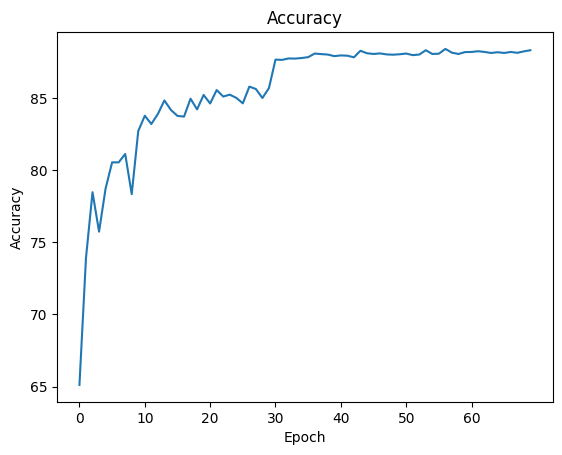

In [12]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()

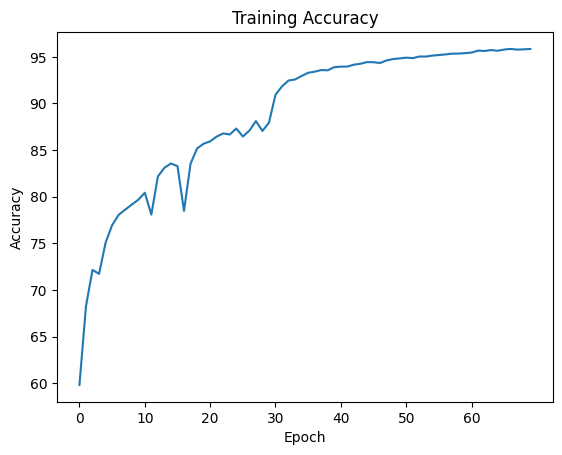

In [13]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()

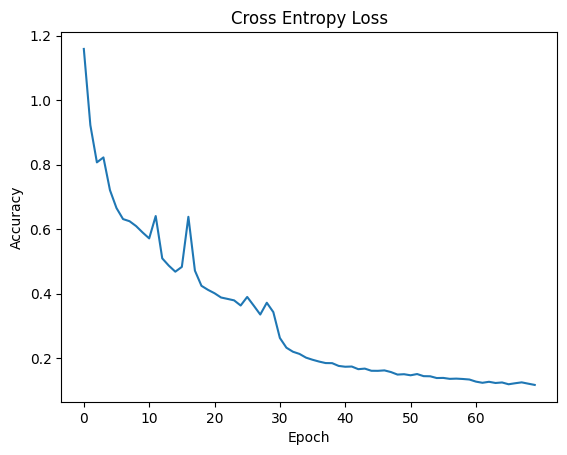

In [14]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()